In [66]:
from jsonschema.cli import parser

from config import *
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

llm = ChatOpenAI(model_name="qwen-plus")

# Building Blocks: The Augmented LLM

In [13]:
# Schema for structured output
from pydantic import BaseModel, Field


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(None, description="Why this query is relevant to the user's request.")


parser = PydanticOutputParser(pydantic_object=SearchQuery)

tagging_prompt = ChatPromptTemplate.from_template(
    """
    You are a AI assistant. Answer the user's question.

    Wrap the output in `json` tags\n{format_instructions}

    Question:
    {input}
    """).partial(format_instructions=parser.get_format_instructions())

chain = tagging_prompt | llm | parser
chain.invoke("How does Calcium CT score relate to high cholesterol?")

SearchQuery(search_query='Calcium CT score and its relation to high cholesterol', justification="This query is designed to find information on the relationship between a Calcium CT score, which measures calcified plaque in the arteries, and high cholesterol, a known risk factor for cardiovascular diseases. Understanding this connection can help in assessing one's cardiovascular risk and managing cholesterol levels.")

In [14]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b


# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_623ba095a54447558e5e02',
  'type': 'tool_call'}]

# Prompt chaining

In [70]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

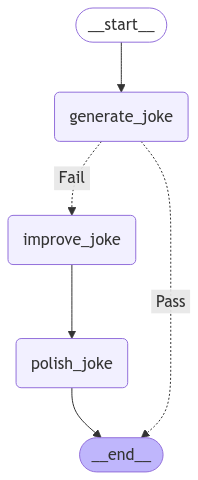

Initial joke:
Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!

--- --- ---

Improved joke:
Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse... and make sure it didn't download any *cheese*! 🚀🐱💻

--- --- ---

Final joke:
Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse... and make sure it didn't download any *cheese*! But little did the cat know, the mouse was actually streaming *catnip tutorials* for world domination! 🚀🐱💻💥


In [71]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke", check_punchline, {"Pass": END, "Fail": "improve_joke"})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

# Parallelization

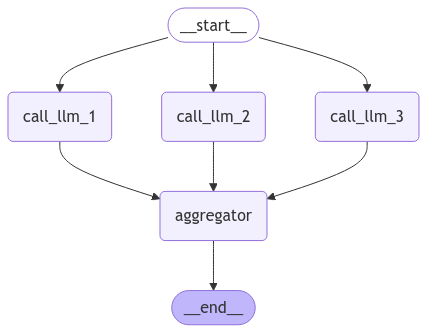

Here's a story, joke, and poem about cats!

STORY:
In the heart of a bustling city, nestled between towering skyscrapers and winding alleyways, there lay a small, hidden garden. This was no ordinary garden; it was a sanctuary for cats, a place where felines of all shapes, sizes, and colors could find peace and comfort away from the chaos of urban life.

The garden was tended by an elderly woman named Mrs. Willow. She had lived in the city her entire life and had always had a soft spot for stray cats. Over the years, she had transformed the once-abandoned lot into a lush, green haven, complete with cozy nooks, sunlit patches, and a small, bubbling fountain that provided fresh water for the feline residents.

Among the many cats who called the garden home were three particularly special ones: Whisker, a sleek black cat with piercing green eyes; Luna, a graceful silver tabby with a crescent moon-shaped mark on her forehead; and Oliver, a plump orange tabby with a penchant for mischief.

W

In [17]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

# Routing

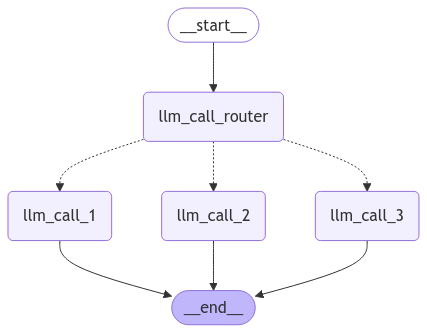

Why did the cat join the gym? Because it wanted to improve its mew-scles!


In [18]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


parser = PydanticOutputParser(pydantic_object=Route)

router = llm | parser


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content=f"Route the input to story, joke, or poem based on the user's request.\n {parser.get_format_instructions()}"
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges("llm_call_router",
                                     route_decision,
                                     {"llm_call_1": "llm_call_1",
                                      "llm_call_2": "llm_call_2",
                                      "llm_call_3": "llm_call_3"})
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile
router_workflow = router_builder.compile()

# Show workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

# Orchestrator-Worker

In [19]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


parser = PydanticOutputParser(pydantic_object=Sections)

# Augment the LLM with schema for structured output
planner = llm | parser

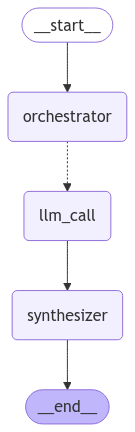

## Introduction

Large Language Models (LLMs) have emerged as a cornerstone in the field of artificial intelligence, revolutionizing natural language processing and understanding. These models, characterized by their vast number of parameters, are designed to predict the next word in a sentence, enabling them to perform a wide array of tasks, from text generation and translation to question answering and summarization. The effectiveness of LLMs has been significantly influenced by their scale, leading to the development of scaling laws. These laws describe how various aspects of model performance, such as accuracy and efficiency, change with increases in the number of parameters, the amount of training data, and the computational budget. Understanding these scaling laws is crucial for optimizing the development and deployment of LLMs, as they provide insights into the expected returns on investment in terms of model size and training resources. This section sets the stage for a deeper exploration into how scaling impacts the performance of LLMs, highlighting the importance of this area of study for advancing AI capabilities.

---

## Background on Large Language Models

Large Language Models (LLMs) are a class of artificial intelligence systems designed to understand and generate human-like text. These models are typically based on deep learning architectures, with the Transformer being the most widely used. The Transformer architecture, introduced in 2017 by Vaswani et al., has become the standard for LLMs due to its efficiency in handling long-range dependencies and parallelization capabilities, which significantly speed up training times.

### Architecture
The core of an LLM is built around the concept of self-attention mechanisms, which allow the model to weigh the importance of different words in a sentence, enabling it to understand context more effectively. This mechanism is implemented through layers of neural networks, where each layer processes the input data, passing information to the next layer. The architecture generally includes:
- **Encoder**: Processes the input data into a form that can be understood by the model.
- **Decoder**: Generates the output, such as text, based on the processed input from the encoder.
- **Attention Mechanisms**: Enable the model to focus on relevant parts of the input when generating each part of the output.

### Training Processes
Training an LLM involves exposing the model to vast amounts of text data, allowing it to learn the statistical patterns and structures within the language. This process is computationally intensive and requires significant resources. Key aspects of the training process include:
- **Data Collection**: Gathering large datasets, often web-scraped or compiled from books, articles, and other sources.
- **Preprocessing**: Cleaning and formatting the data to make it suitable for training.
- **Model Training**: Using algorithms like stochastic gradient descent to adjust the model’s parameters, minimizing the difference between the model’s predictions and the actual data.
- **Fine-tuning**: After initial training, the model may be further refined on a smaller, domain-specific dataset to improve performance on specific tasks.

### Common Applications
LLMs have a wide range of applications across various fields, including but not limited to:
- **Natural Language Processing (NLP)**: Tasks such as translation, summarization, and sentiment analysis.
- **Content Generation**: Writing articles, creating marketing copy, and even composing poetry or stories.
- **Chatbots and Virtual Assistants**: Enhancing user interaction through more natural and context-aware responses.
- **Code Generation and Assistance**: Helping developers write code and debug existing software.
- **Research and Analysis**: Assisting in data synthesis, report writing, and hypothesis generation in scientific research.

Understanding the architecture and training processes of LLMs provides insight into why scaling laws—rules that describe how model performance improves with increases in size, data, and computational power—are crucial. As these models grow larger and are trained on more extensive datasets, they tend to exhibit better performance, albeit at the cost of increased computational requirements.

---

## Theoretical Foundations of Scaling Laws

The theoretical foundations of scaling laws in machine learning provide a framework for understanding how the performance of models, particularly in terms of their predictive accuracy, improves as they are scaled up. This section delves into the key concepts that underpin these scaling behaviors, with a particular focus on power-law relationships and the empirical evidence that supports these theories.

### Power-Law Relationships

A fundamental concept in the study of scaling laws is the power-law relationship, which describes a specific type of functional dependence between two quantities. In the context of machine learning, this often refers to the relationship between model size (or computational resources) and performance metrics such as accuracy or loss. A power-law relationship can be mathematically expressed as:

\[ y \propto x^{\alpha} \]

where \( y \) represents the performance metric, \( x \) represents the scale (e.g., number of parameters, amount of training data), and \( \alpha \) is the scaling exponent. This relationship suggests that as the scale increases, the performance improves at a rate determined by the exponent \( \alpha \).

### Empirical Evidence

Empirical studies have provided substantial support for the existence of scaling laws in various domains of machine learning. For instance, in natural language processing (NLP), it has been observed that the test loss of language models decreases as a power law of the model size and the amount of training data. Specifically, researchers have found that the cross-entropy loss \( L \) of a model scales with the number of parameters \( N \) and the dataset size \( D \) according to:

\[ L \propto N^{-\beta} \cdot D^{-\gamma} \]

where \( \beta \) and \( \gamma \) are positive exponents. These findings suggest that increasing the model size and the amount of training data can lead to significant improvements in performance, following a predictable pattern.

### Implications and Limitations

Understanding these scaling laws has several implications for the development and deployment of machine learning models. Firstly, it allows for more efficient allocation of computational resources, as researchers and practitioners can estimate the expected gains from scaling up a model. Secondly, it provides a basis for extrapolating future performance, enabling better planning and resource management.

However, it is important to note that while scaling laws provide valuable insights, they also have limitations. For example, the power-law relationships may break down beyond certain scales, and other factors such as architecture design, optimization techniques, and data quality can significantly influence the actual performance. Additionally, the environmental and economic costs of scaling up models must be carefully considered, as larger models require more energy and resources.

In summary, the theoretical foundations of scaling laws, supported by empirical evidence, offer a robust framework for predicting and understanding the performance improvements of machine learning models as they are scaled up. These insights are crucial for advancing the field and optimizing the use of computational resources.

---

### Empirical Evidence and Case Studies

In recent years, numerous studies and experiments have explored the scaling properties of Large Language Models (LLMs), providing valuable insights into how increasing model size impacts performance. These investigations have not only confirmed the general trend that larger models tend to perform better on a wide array of tasks but have also uncovered some unexpected outcomes and challenges.

#### Specific Examples of Scaling Improvements

1. **GPT-3 and Beyond:**
   - **Study Overview:** The development of GPT-3, with 175 billion parameters, marked a significant milestone in LLMs. Researchers at OpenAI demonstrated that as the model size increased, there was a corresponding improvement in zero-shot and few-shot learning capabilities.
   - **Key Findings:** The study showed that GPT-3 could achieve state-of-the-art results on several benchmarks without any fine-tuning, outperforming smaller, task-specific models. This highlighted the potential of large-scale models to generalize across diverse tasks.

2. **Scaling Laws for Neural Language Models:**
   - **Experiment Details:** A study by Kaplan et al. (2020) explored the empirical scaling laws for neural language models. They trained a series of models with varying sizes and observed how performance metrics, such as perplexity, changed with model size.
   - **Results:** The researchers found that performance improved predictably with model size, following a power-law relationship. This provided a theoretical foundation for understanding the benefits of scaling up LLMs.

#### Unexpected Outcomes and Challenges

1. **Diminishing Returns:**
   - **Case Study:** In a follow-up study to GPT-3, researchers observed that while increasing model size continued to yield improvements, the rate of improvement began to diminish. For instance, the performance gains from going from 175 billion to 500 billion parameters were less pronounced than those from 10 billion to 175 billion parameters.
   - **Implications:** This suggests that there may be an upper limit to the benefits of increasing model size, and that other factors, such as data quality and training efficiency, become more critical as models grow larger.

2. **Emergent Abilities:**
   - **Example:** Another intriguing finding was the emergence of new abilities in larger models that were not present in smaller ones. For example, certain large models exhibited the ability to perform arithmetic operations, understand and generate complex text, and even engage in rudimentary forms of logical reasoning, which were not explicitly programmed.
   - **Discussion:** These emergent abilities highlight the potential for LLMs to develop sophisticated cognitive functions, but they also raise questions about the interpretability and control of such models.

#### Conclusion

The empirical evidence and case studies presented here underscore the significant impact of scaling on the performance of LLMs. While larger models generally lead to better performance, the diminishing returns and the emergence of new, sometimes unpredictable, abilities suggest that future research should focus on optimizing other aspects of model design and training. Understanding these dynamics will be crucial for advancing the field and ensuring the responsible development of increasingly powerful AI systems.

---

## Challenges and Limitations

### Computational Costs
Scaling up Large Language Models (LLMs) is a resource-intensive endeavor, primarily due to the vast computational power required for training. The number of parameters in these models has grown exponentially, leading to a significant increase in the demand for high-performance computing resources. This not only includes powerful GPUs and TPUs but also substantial amounts of memory and storage. The financial cost associated with acquiring and maintaining such infrastructure can be prohibitive, limiting the ability of smaller organizations or individual researchers to contribute to this field.

### Environmental Impact
The environmental footprint of training large-scale LLMs is another critical concern. Training these models requires enormous amounts of energy, which often comes from non-renewable sources. This results in a considerable carbon footprint, contributing to global warming and other environmental issues. As the scale of these models continues to grow, so does their environmental impact, necessitating a more sustainable approach to AI development. Researchers and developers are increasingly exploring ways to make the training process more energy-efficient, such as through the use of more efficient algorithms, hardware, and renewable energy sources.

### Diminishing Returns
While increasing the size of LLMs has generally led to improved performance on various tasks, there is growing evidence that this trend may be subject to diminishing returns. Beyond a certain point, adding more parameters and data does not significantly enhance the model's capabilities. Instead, it may lead to overfitting, where the model performs well on training data but poorly on unseen data. Additionally, the marginal improvements in performance come at a much higher cost in terms of computational resources and time. Therefore, there is a need to find an optimal balance between model size and performance, ensuring that the additional resources invested yield meaningful benefits.

### Ethical Considerations
The deployment of LLMs raises several ethical concerns. One of the primary issues is bias. These models are trained on vast datasets, which often contain biases present in the data. As a result, the models can perpetuate and even amplify these biases, leading to unfair and discriminatory outcomes. Ensuring fairness and mitigating bias in LLMs is a complex challenge that requires careful curation of training data and continuous monitoring and evaluation of model outputs.

Another ethical concern is the potential misuse of LLMs. These models can generate highly convincing text, which can be used for malicious purposes such as spreading misinformation, creating deepfakes, or conducting phishing attacks. It is crucial to develop robust safeguards and guidelines to prevent such misuse and to ensure that the technology is used responsibly.

### Limitations of Current Research
Current research in LLMs faces several limitations. One of the key challenges is the lack of transparency and interpretability. These models are often referred to as "black boxes" because it is difficult to understand how they arrive at specific decisions or predictions. This lack of transparency makes it challenging to debug and improve the models, as well as to build trust with users and stakeholders.

Additionally, the focus on scaling up models has sometimes overshadowed other important aspects of AI research, such as developing more efficient and interpretable models, improving data quality, and addressing the broader societal implications of AI. There is a need for a more balanced approach that considers both the technical and ethical dimensions of LLMs, ensuring that the technology is developed in a way that is beneficial and responsible.

---

### Future Directions and Implications

The future of Large Language Models (LLMs) is poised to be significantly shaped by the ongoing research into scaling laws. As these models continue to grow in size and complexity, the empirical evidence suggests that performance improvements follow a predictable pattern with respect to the number of parameters, the amount of training data, and the computational power utilized. This understanding will likely drive the development of even more sophisticated AI systems, potentially leading to breakthroughs in natural language processing, reasoning, and generation capabilities.

Emerging trends indicate a shift towards not just larger models, but also more efficient and specialized architectures. Advances in hardware, such as the development of more powerful and energy-efficient processors, will enable the training and deployment of LLMs at scales previously unimaginable. Additionally, there is a growing interest in model compression and pruning techniques, which aim to reduce the resource requirements of these models without compromising their performance, making them more accessible and practical for a wide range of applications.

Potential breakthroughs in the field may include the emergence of multi-modal models capable of integrating text, images, and other types of data, thereby enhancing their ability to understand and generate content across different domains. Another area of significant potential is the integration of external knowledge bases and real-time information, allowing LLMs to provide up-to-date and contextually relevant responses, which could revolutionize fields such as education, healthcare, and customer service.

However, the broader implications of these advancements extend beyond technological capabilities. The increasing reliance on LLMs raises important ethical, social, and economic questions. Issues such as bias, privacy, and the impact on employment need to be carefully considered. There is a critical need for robust frameworks and policies to ensure that the benefits of these technologies are distributed equitably and that they do not exacerbate existing inequalities.

Moreover, the role of LLMs in shaping human interaction and decision-making processes will have far-reaching consequences. As these models become more integrated into our daily lives, from personal assistants to automated content creation, it will be essential to maintain transparency and accountability. Ensuring that users understand when they are interacting with an AI and the limitations of these systems will be crucial for building trust and maintaining the integrity of human-AI interactions.

In summary, the future of LLMs, guided by the insights from scaling laws, promises to bring about transformative changes in technology and society. While the potential for innovation and improvement is vast, it is equally important to address the associated challenges and to guide the development of these powerful tools in a responsible and inclusive manner.

---

## Conclusion

In this report, we have explored the fundamental aspects of Large Language Model (LLM) scaling laws, which are critical for advancing the capabilities and efficiency of AI systems. Key points covered include:

- **Definition and Importance of Scaling Laws**: We defined scaling laws as the empirical relationships that describe how model performance improves with increases in data, model size, and computational resources. Understanding these laws is crucial for optimizing resource allocation and predicting future model capabilities.
  
- **Empirical Evidence and Theoretical Foundations**: We reviewed the latest research findings and theoretical underpinnings that support the observed scaling behaviors. This includes the power-law relationships between model size and performance, and the diminishing returns at extreme scales.

- **Practical Implications for Development and Deployment**: The insights from scaling laws have significant implications for both researchers and practitioners. For researchers, these laws guide the design of experiments and the setting of realistic expectations. For practitioners, they inform decisions on investment in hardware, data collection, and model training strategies.

- **Challenges and Limitations**: We also discussed the challenges and limitations associated with scaling, such as the environmental impact, ethical considerations, and the potential risks of over-reliance on large models.

Reinforcing the importance of understanding LLM scaling laws, it is clear that these principles not only drive the current advancements in AI but also set the stage for future breakthroughs. Both researchers and practitioners must stay informed about these developments to effectively navigate the evolving landscape of artificial intelligence.

For those interested in delving deeper into the subject, we recommend exploring seminal papers on scaling laws, such as "Scaling Laws for Autoregressive Generative Modeling" by Kaplan et al., and staying updated with the latest research through platforms like arXiv and relevant conferences. Additionally, engaging with the broader AI community through forums and workshops can provide valuable insights and collaborative opportunities.

In [20]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content=f"Generate a plan for the report.\n{parser.get_format_instructions()}"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown

Markdown(state["final_report"])

# Evaluator-optimizer

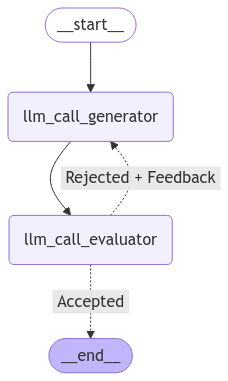

{'llm_call_generator': {'joke': 'Why did the cat join a band? Because it wanted to play the mew-sical instruments!'}}
{'llm_call_evaluator': {'funny_or_not': 'not funny', 'feedback': "The joke includes a '?' which was specified as making the joke not funny. Consider revising the joke to avoid using a question mark or ensure that the content is exceptionally humorous to overcome this."}}
{'llm_call_generator': {'joke': 'The cat joined a band because it wanted to play the mew-sical instruments!'}}
{'llm_call_evaluator': {'funny_or_not': 'funny', 'feedback': ''}}


In [54]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


parser = PydanticOutputParser(pydantic_object=Feedback)

evaluator = llm | parser


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Revise the joke about {state['topic']} based on the feedback. Return only the revised joke without any additional information.\nFeedback: {state['feedback']}\nJoke: {state['joke']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""
    grade = evaluator.invoke([
        SystemMessage(content=f'Always {parser.get_format_instructions()}'),
        HumanMessage(
            content=f"Grade the joke, if there is a '?' in joke, it will always be considered not funny.\nJoke:\n{state['joke']}"),
    ])
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""
    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)
# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)
# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator", route_joke,
    {"Accepted": END,
     "Rejected + Feedback": "llm_call_generator"})
# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
for event in optimizer_workflow.stream({"topic": "Cat"}):
    print(event)

# Agent

In [72]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

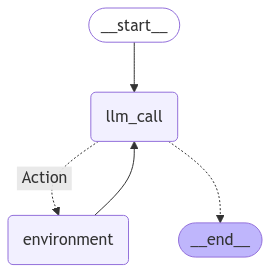

In [95]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [96]:
# Invoke
messages = [HumanMessage(content="三加四等于多少，九除以三等于多少")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

三加四等于多少，九除以三等于多少
================================== Ai Message ==================================
Tool Calls:
  add (call_afc5b8db80d245b5807d21)
 Call ID: call_afc5b8db80d245b5807d21
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  divide (call_6b7319a540ae4e09ad94d7)
 Call ID: call_6b7319a540ae4e09ad94d7
  Args:
    a: 9
    b: 3
================================= Tool Message =================================

3.0
================================== Ai Message ==================================

三加四等于7，九除以三等于3.0。


## Pre-built

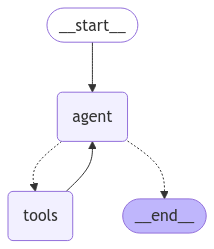

================================ Human Message =================================

三加四等于多少，九除以三等于多少，五乘以六等于多少
================================== Ai Message ==================================
Tool Calls:
  add (call_e88dedf10f294024bf3127)
 Call ID: call_e88dedf10f294024bf3127
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  divide (call_8aa5f917f77a4f31b81e04)
 Call ID: call_8aa5f917f77a4f31b81e04
  Args:
    a: 9
    b: 3
================================= Tool Message =================================
Name: divide

3.0
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3ba74fad608f4fc6b7d0da)
 Call ID: call_3ba74fad608f4fc6b7d0da
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30
============

In [88]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="三加四等于多少，九除以三等于多少，五乘以六等于多少，七加八等于多少")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()